In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [10]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.cn1 = nn.Conv2d(1, 16, 3, 1)   # channel, output, kernel, stride
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(12 * 12* 32, 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)

        return op

In [41]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()

    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y)
        loss.backward()
        optim.step()

        if b_i % 10 == 0:
            print("Epoch: {} [{}/{} ({:.0f}%)] \t Train Loss: {:.6f}"
            .format(epoch, b_i * len(X), len(train_dataloader.dataset),
            100. * (b_i / len(train_dataloader)), loss.item()))

In [66]:
def test(model, device, test_dataloader):
    model.eval()
    loss, success = 0, 0
    
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction="sum").item()
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)
    print("\nTest Dataset")
    print("Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)"
    .format(loss, success, len(test_dataloader.dataset), 100. * (success / len(test_dataloader.dataset))))

In [67]:
train_dataloader = DataLoader(datasets.MNIST("../data", train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                   transforms.Normalize((0.1302,), (0.3069))])),batch_size=32, shuffle=True)

test_dataloader = DataLoader(datasets.MNIST("../data", train=False, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                   transforms.Normalize((0.1302,), (0.3069))])),batch_size=32, shuffle=False)

In [68]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

In [70]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

Epoch: 1 [0 / 60000 (0%)] 	 Train Loss: 0.065752
Epoch: 1 [320 / 60000 (1%)] 	 Train Loss: 0.046321
Epoch: 1 [640 / 60000 (1%)] 	 Train Loss: 0.182308
Epoch: 1 [960 / 60000 (2%)] 	 Train Loss: 0.100019
Epoch: 1 [1280 / 60000 (2%)] 	 Train Loss: 0.046793
Epoch: 1 [1600 / 60000 (3%)] 	 Train Loss: 0.004141
Epoch: 1 [1920 / 60000 (3%)] 	 Train Loss: 0.088554
Epoch: 1 [2240 / 60000 (4%)] 	 Train Loss: 0.027893
Epoch: 1 [2560 / 60000 (4%)] 	 Train Loss: 0.172537
Epoch: 1 [2880 / 60000 (5%)] 	 Train Loss: 0.014431
Epoch: 1 [3200 / 60000 (5%)] 	 Train Loss: 0.053399
Epoch: 1 [3520 / 60000 (6%)] 	 Train Loss: 0.008097
Epoch: 1 [3840 / 60000 (6%)] 	 Train Loss: 0.085096
Epoch: 1 [4160 / 60000 (7%)] 	 Train Loss: 0.018852
Epoch: 1 [4480 / 60000 (7%)] 	 Train Loss: 0.032551
Epoch: 1 [4800 / 60000 (8%)] 	 Train Loss: 0.041550
Epoch: 1 [5120 / 60000 (9%)] 	 Train Loss: 0.176699
Epoch: 1 [5440 / 60000 (9%)] 	 Train Loss: 0.147903
Epoch: 1 [5760 / 60000 (10%)] 	 Train Loss: 0.092533
Epoch: 1 [6080 / 

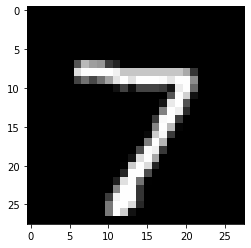

In [75]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap="gray", interpolation="none")

In [77]:
print(f"Model Prediction: {model(sample_data).data.max(1)[1][0]}")
print(f"Ground Truth: {sample_targets[0]}")

Model Prediction: 7
Ground Truth: 7
